# Group-by From Scratch

*This notebook originally appeared as a post on*
[*Pythonic Perambulations*](http://jakevdp.github.io/blog/2017/03/22/group-by-from-scratch/)
*by Jake Vanderplas.  The code is MIT-licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

I've found one of the best ways to grow in my scientific coding is to spend time comparing the efficiency of various approaches to implementing particular algorithms that I find useful, in order to build an intuition of the performance of the building blocks of the scientific Python ecosystem.

In this vein, today I want to take a look at an operation that is in many ways fundamental to data-driven exploration: the group-by, otherwise known as the [split-apply-combine](https://www.jstatsoft.org/article/view/v040i01) pattern.
An architypical example of a summation group-by is shown in this figure, borrowed from the [Aggregation and Grouping](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb) section of the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook):

![split-apply-combine diagram](https://jakevdp.github.io/figures/split-apply-combine.svg)

The basic idea is to split the data into groups based on some value, apply a particular operation to the subset of data within each group (often an aggregation), and then combine the results into an output dataframe.
Python users generally turn to the [Pandas](http://pandas.pydata.org) library for this type of operation, where it is is implemented effiently via a concise object-oriented API:

<!-- PELICAN_END_SUMMARY -->

In [1]:
keys   = ['A', 'B', 'C', 'A', 'B', 'C']
vals = [ 1,   2,   3,   4,   5,   6 ]

In [2]:
import pandas as pd
pd.Series(vals).groupby(keys).sum()

A    5
B    7
C    9
dtype: int64

An oft-repeated claim in the Python world is that doing this sort of operation efficiently requires Pandas — that tools provided in NumPy and SciPy are useful for elementwise operations, but not group-wise operations.
This is a claim I've repeated often in my own teaching and writing, but I found myself recently wondering if it's really true.

Below I'll explore this question by approaching the group-by summation from a number of angles, taking advantage of both built-in Python operations and operations provided by NumPy and SciPy.
I hope that through this, you will gain some intuition for the performance of various algorithmic building-blocks available in the PyData ecosystem, and how you might apply them effectively to solve your own problems.

## Timing Functions

For convenience, let's start by defining some functionality that will let us quickly profile and visualize group-by functionality.
We'll assume that the operations to be profiled will come in the form of a function that takes a list of keys and values, and returns a dictionary of summed groups.
For example:

In [3]:
def pandas_groupby(keys, vals):
    return pd.Series(vals).groupby(keys).sum().to_dict()

pandas_groupby(keys, vals)

{'A': 5, 'B': 7, 'C': 9}

To avoid rerunning of identical benchmarks within the notebook, I'll make use of Python's ``functools.lru_cache`` decorator, which can cache the results of long-running functions, returning the cached value if the function is called again with the same inputs:

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from functools import lru_cache

# timeit magic requires global variables, so define them here
timeitfunc = None
timeitkeys = None
timeitvals = None


@lru_cache(maxsize=256)
def _bench_one(func, n_group, size, rseed=754389):
    """Compute a timing and cache it for later use"""
    global timeitfunc, timeitkeys, timeitvals
    rand = np.random.RandomState(rseed)
    timeitkeys = rand.randint(0, n_group, size)
    timeitvals = rand.rand(size)
    timeitfunc = func
    # Following is a magic function; only works in IPython/Jupyter
    t = %timeit -oq timeitfunc(timeitkeys, timeitvals)
    return t.best


def bench(funcs, n_groups, sizes):
    """Run a set of benchmarks and return as a dataframe"""
    n_groups, sizes = np.broadcast_arrays(n_groups, sizes)
    names = [func.__name__.split('_')[0] for func in funcs]
    timings = {name: [_bench_one(func, n_group, size)
                      for n_group, size in zip(n_groups, sizes)]
               for name, func in zip(names, funcs)}
    ind = pd.MultiIndex.from_arrays([n_groups, sizes],
                                    names=['num_groups', 'size'])
    return pd.DataFrame(timings, index=ind)[names]


def plot_benchmarks(funcs, n_groups=None, sizes=None):
    """Plot the benchmarks as a function of data size and number of groups"""
    if n_groups is None:
        n_groups = (10 ** np.linspace(0, 4, 10)).astype(int)
    if sizes is None:
        sizes = (10 ** np.linspace(2, 6, 10)).astype(int)
    timings_sizes = bench(funcs, 10, sizes).reset_index('num_groups', drop=True)
    timings_groups = bench(funcs, n_groups, 10000).reset_index('size', drop=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
    timings_sizes.plot(ax=ax[0], logx=True, logy=True)
    ax[0].set(xlabel='size of dataset', ylabel='seconds',
              title='Varying dataset size with 10 groups')
    timings_groups.plot(ax=ax[1], logx=True, logy=True)
    ax[1].set(xlabel='number of groups', ylabel='seconds',
              title='Varying number of groups with 10000 elements')

    return fig

With this setup in place, we can plot some benchmarks of the Pandas approach with a single concise command:

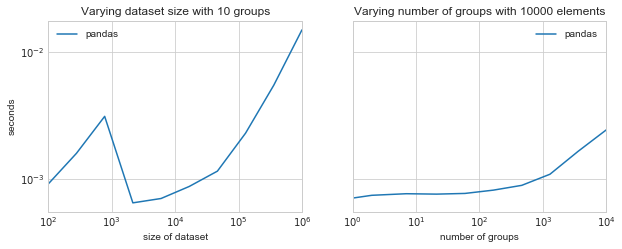

In [5]:
plot_benchmarks([pandas_groupby]);

For the Pandas Groupby operation, there is some non-trivial scaling for small datasets, and as data grows large it execution time is approximately linear in the number of data points.
The pandas groupby is implemented in [highly-optimized cython code](https://github.com/pandas-dev/pandas/blob/master/pandas/_libs/algos_groupby_helper.pxi.in), and provides a nice baseline of comparison for our exploration.

Let's now take a look at some approaches by which we can implement this operation from scratch.

## Group-by with Python dicts

A simple Python implementation of this might use some straightforward loops over Python dictionaries:

In [6]:
result = {}
for key, val in zip(keys, vals):
    if key not in result:
        result[key] = 0
    result[key] += val
print(result)

{'A': 5, 'B': 7, 'C': 9}


This is simple enough, but we can remove the conditional by using the built-in ``defaultdict`` collection, which automatically initializes values when they are referenced.
Wrapping this in a function gives:

In [7]:
from collections import defaultdict

def dict_groupby(keys, vals):
    count = defaultdict(int)
    for key, val in zip(keys, vals):
        count[key] += val
    return dict(count)

dict_groupby(keys, vals)

{'A': 5, 'B': 7, 'C': 9}

With this function defined, we can compare the performance to the Pandas function:

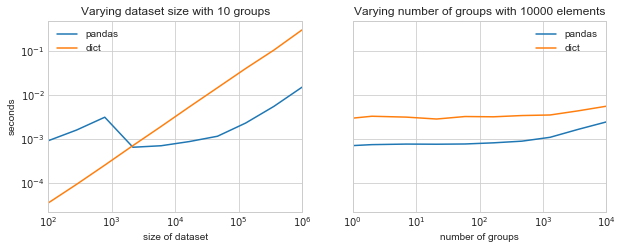

In [8]:
plot_benchmarks([pandas_groupby, dict_groupby]);

The dictionary implementation has very predictable linear scaling with the size of the data, because it relies on a single pass through the dataset.
Evidently, up to a couple thousand elements, this simple Python approach can even out-perform the Pandas operation, but as the number of points grows, the dict-based implementation becomes far slower than the optimized Pandas code.

## Itertools approach

As another approach to the pure-Python group-by, you might be tempted to turn to the ``itertools.groupby`` function that is included in the standard library.
Upon further inspection, this is somewhat complicated by the fact that this operation requires groups to appear sequentially in the input, which necessitates a pre-sorting of the data in order to properly group all keys.

Here's one possible implementation:

In [9]:
from itertools import groupby
from operator import itemgetter

def itertools_groupby(keys, vals):
    get_key, get_val = itemgetter(0), itemgetter(1)
    sorted_pairs = sorted(zip(keys, vals), key=get_key)
    return {key: sum(map(get_val, values))
            for key, values in groupby(sorted_pairs, get_key)}

itertools_groupby(keys, vals)

{'A': 5, 'B': 7, 'C': 9}

Let's see how this compares:

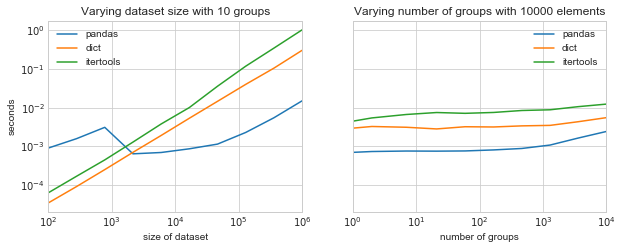

In [10]:
plot_benchmarks([pandas_groupby, dict_groupby, itertools_groupby]);

We see that the itertools approach has similar scaling to the dict-based approach, but unsurprisingly is quite a bit slower due to the required multiple passes over the data, one of which is a relatively expensive sorting operation.

## NumPy-based approaches

When working with large arrays, one way to speed things up is to use NumPy's element-wise operations to push loops from the interpreted Python layer into the compiled C layer.
For example, selections in Numpy are most often done via [masking](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb) operations, which can be combined with a Python dict comprehension for a nice concise implementation of the group-by:

In [11]:
import numpy as np

def masking_groupby(keys, vals):
    keys = np.asarray(keys)
    vals = np.asarray(vals)
    return {key: vals[keys == key].sum()
            for key in np.unique(keys)}
    
masking_groupby(keys, vals)

{'A': 5, 'B': 7, 'C': 9}

Built-in to each masking operation is a full pass over the data, and the construction of an associated Boolean array.
These passes happen within the compiled layer of NumPy, and so in practice end up being faster than the pure-Python loops we saw previously:

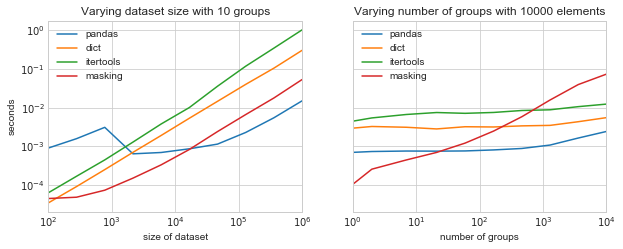

In [12]:
plot_benchmarks([pandas_groupby, dict_groupby,
                 itertools_groupby, masking_groupby]);

Interestingly, when the number of groups is small, this approach can beat even the specialized code in Pandas.
When the number of groups is large, however, the one-pass-per-group requirement negates that gain.
Numpy will not be able to match the scaling of Pandas unless it can identify all groups in a single pass over the data.

Single-pass identification of all groups is actually possible with the low-level routine ``np.bincount``, which performs a weighted count of the number of occurrences of values in an array of integers.
To use it, we must first map all our values to unique integers, which can be done with the ``np.unique`` function.
The result is a concise and efficient two-pass group-by implementation:

In [13]:
import numpy as np

def bincount_groupby(keys, vals):
    unique_keys, group = np.unique(keys, return_inverse=True)
    counts = np.bincount(group, weights=vals)
    return dict(zip(unique_keys, counts))

bincount_groupby(keys, vals)

{'A': 5.0, 'B': 7.0, 'C': 9.0}

Let's add this to the benchmark plot:

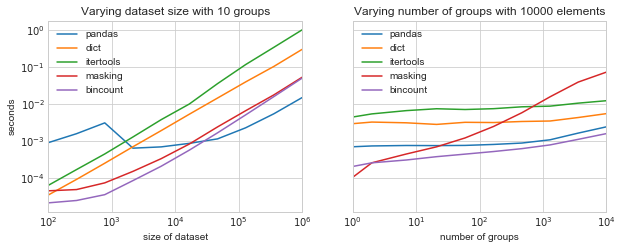

In [14]:
plot_benchmarks([pandas_groupby, dict_groupby, itertools_groupby,
                 masking_groupby, bincount_groupby]);

Compared to our masking-based approach, the result has similar scaling with dataset size, while avoiding the poor behavior for large numbers of groups.

While it is interesting that an implementation based on generic building blocks in NumPy can approach the performance of purpose-optimized code in Pandas, there remains the problem that the bincount approach is not particularly flexible: for example, a ``min`` or ``max`` aggregation cannot be implemented as a weighted sum.

## Sparse matrix approach

For a more flexible approach still based on generic building blocks available in the standard stack, I'll consider something that requires a bit of out-of-the-box thinking.
In my experience, some of the most useful low-level routines in the PyData stack are found within the SciPy sparse matrix module: while they are designed for fast manipulation of sparse matrices, they can often be re-purposed and used to solve conceptually distinct problems.

In this case, we can leverage these tools by constructing a sparse matrix such that each group occupies a single row of the matrix, and then perform a standard aggregation over that matrix to find our desired result.
We'll again take advantage of ``np.unique`` to identify the appropriate row/group for each value, and use this to build the matrix:

In [15]:
from scipy import sparse

def sparse_groupby(keys, vals):
    unique_keys, row = np.unique(keys, return_inverse=True)
    col = np.arange(len(keys))
    mat = sparse.coo_matrix((vals, (row, col)))
    return dict(zip(unique_keys, mat.sum(1).flat))

sparse_groupby(keys, vals)

{'A': 5, 'B': 7, 'C': 9}

Let's add this to our benchmarks:

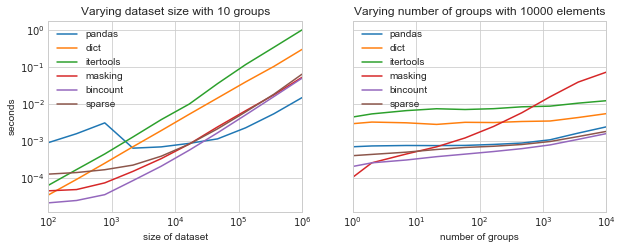

In [16]:
plot_benchmarks([pandas_groupby, dict_groupby, itertools_groupby,
                 masking_groupby, bincount_groupby, sparse_groupby]);

Even for larger arrays, this sparse approach comes surprisingly close (within a factor of a few) to the purpose-built group-by implementation within Pandas, and also provides the wide range of efficient aggregation options available to sparse matrices.
This exercise in repurposing the sparse matrix internals might seem a bit frivolous in this specific case, but in my own research work I've often found similar approaches useful in efficient implementation of algorithms that might otherwise necessitate writing a custom C extension.

I hope you found this discussion useful, and please let me know in the comments if you can think of other clever ways to implement fast group-by functionality in Python!

*This post was written in an IPython notebook, which can be downloaded*
[*here*](http://jakevdp.github.io/downloads/notebooks/GroupBy.ipynb),
*or viewed statically on*
[*nbviewer*](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/GroupBy.ipynb).